# Praktikum 1

Klasifikasi Gambar (Day vs Night) dengan Neural Network.

# Membangun & Ekspor Model

Pada praktikum bagian pertama ini, kita akan melatih model dan menyimpan "artefak" (file hasil training) yang dibutuhkan untuk deployment. Dengan melakukan Klasifikasi Gambar (Day vs Night) mengunakan Neural Network.


In [8]:
import os, gdown, zipfile
if not os.path.isdir('./images'):
    gdown.download(id='1KZahLtkTW6fpcY60lAMCanRJ_HOFqZcK', output='images.zip')
    with zipfile.ZipFile('images.zip', 'r') as zip_ref:
        zip_ref.extractall()
    os.remove('images.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1KZahLtkTW6fpcY60lAMCanRJ_HOFqZcK
From (redirected): https://drive.google.com/uc?id=1KZahLtkTW6fpcY60lAMCanRJ_HOFqZcK&confirm=t&uuid=89ecad58-1571-4cfc-9171-f5e57cd71d13
To: f:\NaniKaSuru\Polinema\Machine-Learning-2025\JS15\images.zip
100%|██████████| 28.8M/28.8M [00:04<00:00, 6.00MB/s]


## Langkah 1: Import Library dan Mount Google Drive

Langkah pertama adalah mengimpor pustaka yang diperlukan untuk pengolahan citra, machine learning, dan deep learning, serta menghubungkan Google Colab dengan Google Drive.

In [9]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

# from google.colab import drive
# drive.mount('/content/drive')

## Langkah 2: Load Dataset

Membaca gambar dari direktori training dan testing, lalu menyimpannya dalam list bersama dengan labelnya.

Catatan: Sesuaikan path dengan lokasi folder images di Google Drive Anda masing-masing.

In [10]:
# Load images and labels from a directory structure
def load_dataset(img_dir):
    p = Path(img_dir)
    img_list = []
    for folder in p.glob('*'):
        label = folder.name
        for file in folder.glob('*.jpg'):
            img = cv2.imread(str(file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_list.append((img, label))
    return img_list

# train_dir = "/content/drive/MyDrive/FolderAnda/images/training/"
# test_dir  = "/content/drive/MyDrive/FolderAnda/images/test"

train_dir = "./images/training/"
test_dir  = "./images/test"


train_img = load_dataset(train_dir)
test_img  = load_dataset(test_dir)

print(f"Jumlah data training: {len(train_img)}")
print(f"Jumlah data testing: {len(test_img)}")

Jumlah data training: 240
Jumlah data testing: 160


## Langkah 3: Preprocessing (Resize & Label Encoding)

Mengubah ukuran gambar menjadi 256x256 piksel dan mengubah label teks ('day'/'night') menjadi angka biner (1/0).

In [11]:
# Preprocess images: resize and encode labels
def resize_image(img, size=(256,256)):
    return cv2.resize(img, size)

def label_encoder(label):
    return 1 if label == 'day' else 0

def preprocess(img_list):
    X = []
    y = []
    for img, label in img_list:
        img_std = resize_image(img)
        X.append(img_std)
        y.append(label_encoder(label))
    return X, y

X_train_img, y_train = preprocess(train_img)
X_test_img,  y_test  = preprocess(test_img)

## Langkah 4: Ekstraksi Fitur HOG (Histogram of Oriented Gradients)

Mengekstraksi fitur bentuk dan tekstur dari gambar menggunakan metode HOG.


In [12]:
# Extract HOG features
def extract_hog(X_imgs):
    feats = []
    for img in X_imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_feat = hog(gray,
                       orientations=9,
                       pixels_per_cell=(8,8),
                       cells_per_block=(2,2),
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
        feats.append(hog_feat)
    return np.array(feats)

X_train_feat = extract_hog(X_train_img)
X_test_feat  = extract_hog(X_test_img)

## Langkah 5: Normalisasi Fitur

Menstandarisasi fitur agar memiliki rata-rata 0 dan variansi 1 menggunakan StandardScaler.

In [13]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)

## Langkah 6: Split Data Training & Validation

Memisahkan data training menjadi data train dan validation.

In [14]:
# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42
)

## Langkah 7: Konversi Label ke Numpy Array

Mengubah list label menjadi format numpy array agar kompatibel dengan TensorFlow/Keras.

In [15]:
# Convert labels to numpy arrays (required for Keras)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

## Langkah 8: Membangun Arsitektur Model Neural Network

Membuat model Sequential dengan 3 layer (Input, Hidden Layers dengan ReLU, dan Output Layer dengan Sigmoid).

In [16]:
# Build a simple feedforward neural network
# Define model architecture
# input_dim is the number of features in the dataset
# Hidden layer -> 128 neurons, ReLU activation
# Hidden layer -> 64 neurons, ReLU activation
# Output layer -> 1 neuron, Sigmoid activation (for binary classification)
input_dim = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     4,428,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,737 (16.92 MB)

 Trainable params: 4,436,737 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

Langkah 9: Training Model

Melatih model menggunakan data training selama 20 epoch.

In [17]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8229 - loss: 0.9394 - val_accuracy: 0.9583 - val_loss: 0.1116
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9844 - loss: 0.0730 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9948 - loss: 0.0306 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 3.4205e-05 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 1.9345e-04 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 9.0280e-05 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 3.7908e-05 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 2.5380e-05 - val_accuracy: 1.0000

## Langkah 10: Evaluasi Model

Menguji performa model pada data testing.

In [18]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print("Akurasi Test:", test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9438 - loss: 0.8029 
Akurasi Test: 0.9437500238418579


## Langkah 11: Prediksi dan Laporan Klasifikasi serta Visualisasi

Membuat prediksi pada data test dan menampilkan classification report serta confusion matrix.

In [19]:
# Generate classification report and confusion matrix
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        80
           1       1.00      0.89      0.94        80

    accuracy                           0.94       160
   macro avg       0.95      0.94      0.94       160
weighted avg       0.95      0.94      0.94       160

[[80  0]
 [ 9 71]]


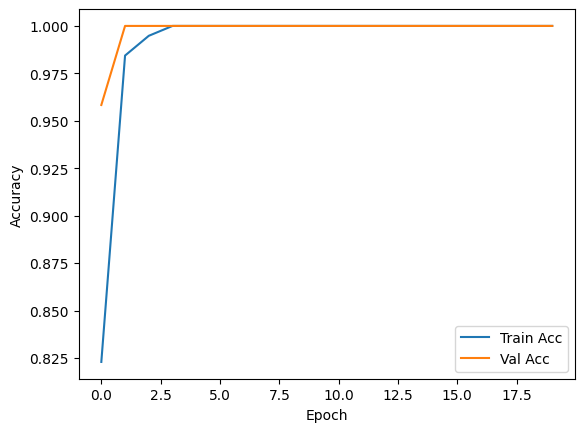

In [20]:
# Visualize training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Langkah 12: Menyimpan Model dan Scaler

Menyimpan model yang sudah dilatih ke dalam format .h5 dan scaler ke format .pkl untuk penggunaan deployment.

In [21]:
# Save the trained model
import pickle

# 1. Simpan Model
# Menggunakan format .h5
model.save('day_night_model.h5')
print("✅ Model berhasil disimpan sebagai: day_night_model.h5")

# 2. Simpan Scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler berhasil disimpan sebagai: scaler.pkl")

✅ Model berhasil disimpan sebagai: day_night_model.h5
✅ Scaler berhasil disimpan sebagai: scaler.pkl
